# Using Text Mining to  Compare Trump's (2020) and Obama's (2016) State of the Union Address

## Using the r package rvest, I was able to web scrape Trump's (2020) and Obama's (2016) state of the union addresses. I will create a different post that displays how I extracted the text from each webpage. 

### Import Libraries

In [24]:
options(warn=-1)
# Import libraries
library(tidyverse) #Reading csv files
library(tidytext) #Sentiment analysis and text analytics 
library(tm) #Data cleaning 
library(scales) #For data visualization 
library(scales) #For data visualization 

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --
v tibble  3.0.1     v stringr 1.4.0
v tidyr   1.0.2     v forcats 0.5.0
v purrr   0.3.4     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x ggplot2::annotate()  masks NLP::annotate()
x scales::col_factor() masks readr::col_factor()
x purrr::discard()     masks scales::discard()
x dplyr::filter()      masks stats::filter()
x dplyr::lag()         masks stats::lag()


### Import state of the union addresses and visualize data frames 

In [25]:
#Import using readr 
Obama_2016 <- read_csv('obama_2016.csv')
Trump_2020 <- read_csv('trump_2020.csv')

#Display Obama data frame
print("Obama 2016")
head(Obama_2016)

#Display Trump data frame
print("Trump 2020")
head(Trump_2020)

Parsed with column specification:
cols(
  X1 = col_double(),
  text = col_character(),
  President = col_character()
)
Parsed with column specification:
cols(
  X1 = col_double(),
  text = col_character(),
  President = col_character()
)


[1] "Obama 2016"


X1,text,President
1,"Mr. Speaker, Mr. Vice President, Members of Congress, my",Obama_2016
2,fellow Americans: Tonight marks the eighth year I've come here to,Obama_2016
3,"report on the State of the Union. And for this final one, I'm going to",Obama_2016
4,try to make it shorter. I know some of you are antsy to get back to,Obama_2016
5,"Iowa. I also understand that because it's an election season,",Obama_2016
6,"expectations for what we'll achieve this year are low. Still, Mr.",Obama_2016


[1] "Trump 2020"


X1,text,President
1,"Madam Speaker, Mr. Vice President, Members of Congress, the First Lady",Trump_2020
2,"of the United States, and my fellow citizens: Three years ago, we",Trump_2020
3,"launched the great American comeback. Tonight, I stand before you to",Trump_2020
4,"share the incredible results. Jobs are booming, incomes are soaring,",Trump_2020
5,"poverty is plummeting, crime is falling, confidence is surging, and our",Trump_2020
6,country is thriving and highly respected again! America<U+0092>s enemies are,Trump_2020


## Let's start by calculating the frequency of each word that occurs in both speeches. 


In [8]:
#Combine both data frames
state_of_the_union_df <- rbind(Obama_2016, Trump_2020)

#Perform tokenization and calculate word frequencies 
state_of_the_union_df_tidy <- state_of_the_union_df %>%
     group_by(President) %>%
	   unnest_tokens(word, text) %>% 
     count(word, sort = T)

#Display new data frame
head(state_of_the_union_df_tidy)


President,word,n
Trump_2020,the,291
Obama_2016,the,265
Trump_2020,and,197
Obama_2016,and,189
Obama_2016,to,189
Trump_2020,to,161


## Plot the top 10 most frequent words to get a sense of some of the common words in both speeches. 

Selecting by n


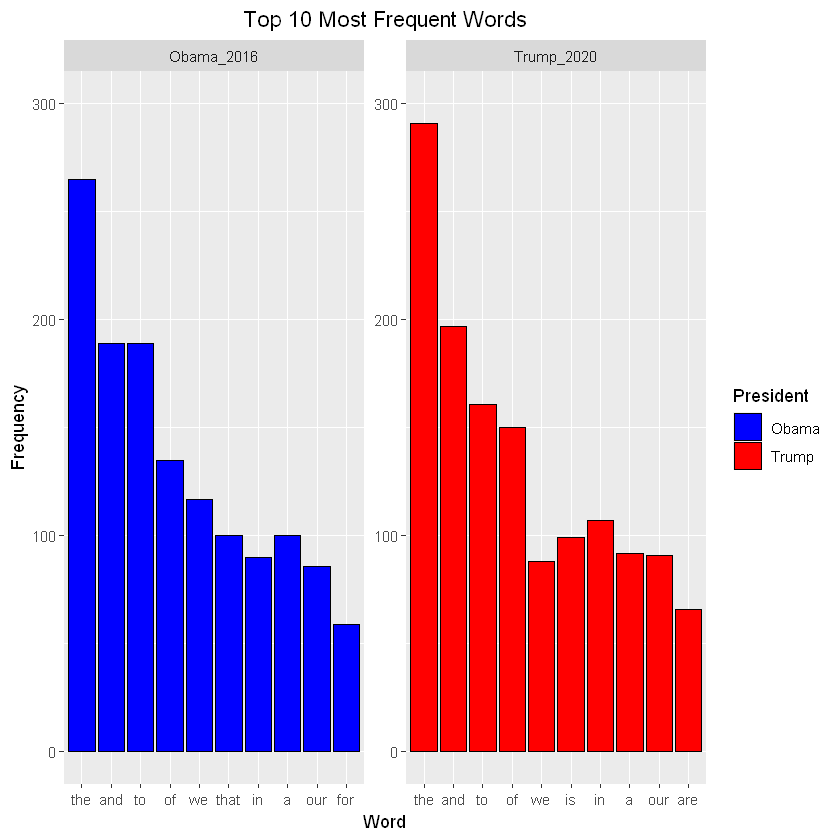

In [26]:
#Pull top 10 most frequent words from each speech
top_10_df <- top_n(state_of_the_union_df_tidy, 10) 

# Use plot the most frequent words
ggplot(data = top_10_df, aes(x = reorder(word, -n), y = n, fill = President)) +
        geom_col(color = 'black') +
        facet_wrap(~ President, scales = "free") +
        ylim(0, 300) +
        xlab("Word") +
        ylab("Frequency") +
        scale_fill_manual(labels = c("Obama", "Trump"), values = c("blue", "red")) +
        ggtitle("Top 10 Most Frequent Words") +
        theme(plot.title = element_text(hjust = 0.5)) 


## When you look at these words, they do not seem informative. Most of these words are common words, known as stopwords. These words can be filtered out.  

Joining, by = "word"
Selecting by n


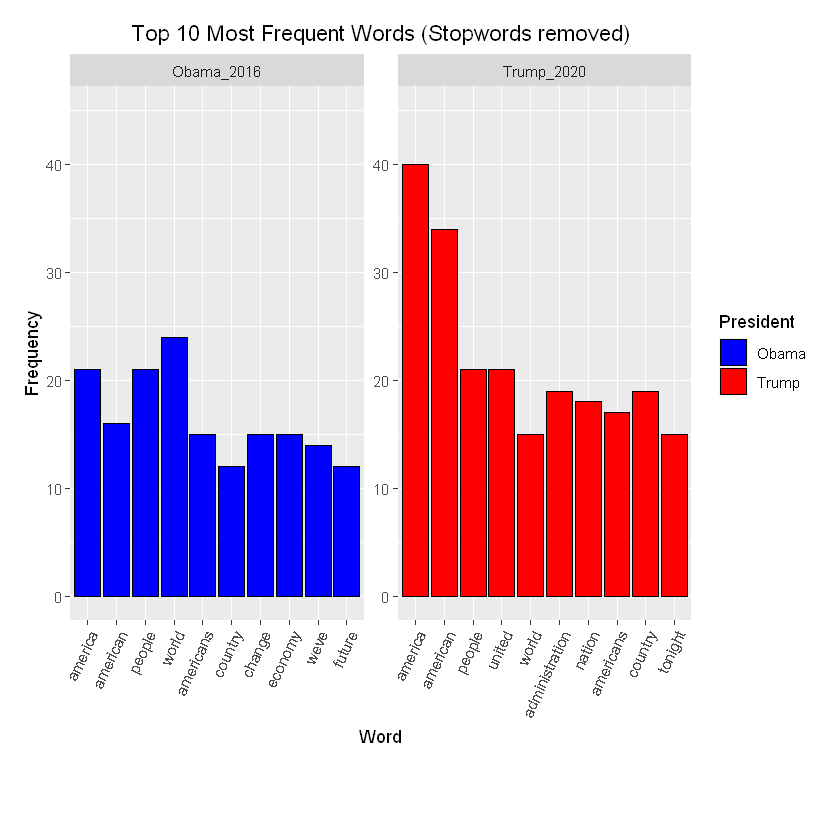

In [27]:
#More data preprocessing
state_of_the_union_df$text <- removeNumbers(state_of_the_union_df$text) #Remove number from speech
state_of_the_union_df$text <- removePunctuation(state_of_the_union_df$text) #Remove punctuation


#Perform the anti_join operation on the state_of_the_union_df_tidy data frame
state_of_the_union_removed_stopwords <- state_of_the_union_df %>%
     group_by(President) %>%
	   unnest_tokens(word, text, to_lower = TRUE) %>% 
     anti_join(stop_words) %>%
     count(word, sort = T) 

#Pull top 10 most frequent words from each speech
top_10_df_nostop <- top_n(state_of_the_union_removed_stopwords, 10) 

# Use plot the most frequent words
ggplot(data = top_10_df_nostop, aes(x = reorder(word, -n), y = n, fill = President )) +
        geom_col(color = 'black') +
        facet_wrap(~ President, scales = "free") +
        ylim(0, 45) +
        xlab("Word") +
        ylab("Frequency") +
        scale_fill_manual(labels = c("Obama", "Trump"), values = c("blue", "red")) +
        ggtitle("Top 10 Most Frequent Words (Stopwords removed)") +
        theme(plot.title = element_text(hjust = 0.5), plot.margin = unit(c(5, 5, 20, 5) ,"mm"),
             axis.text.x = element_text(angle = 65, hjust = 1)) 

### That looks much better. 

# Now, let's visualize the similarity between Obama's (2016) and Trump's (2020) speeches


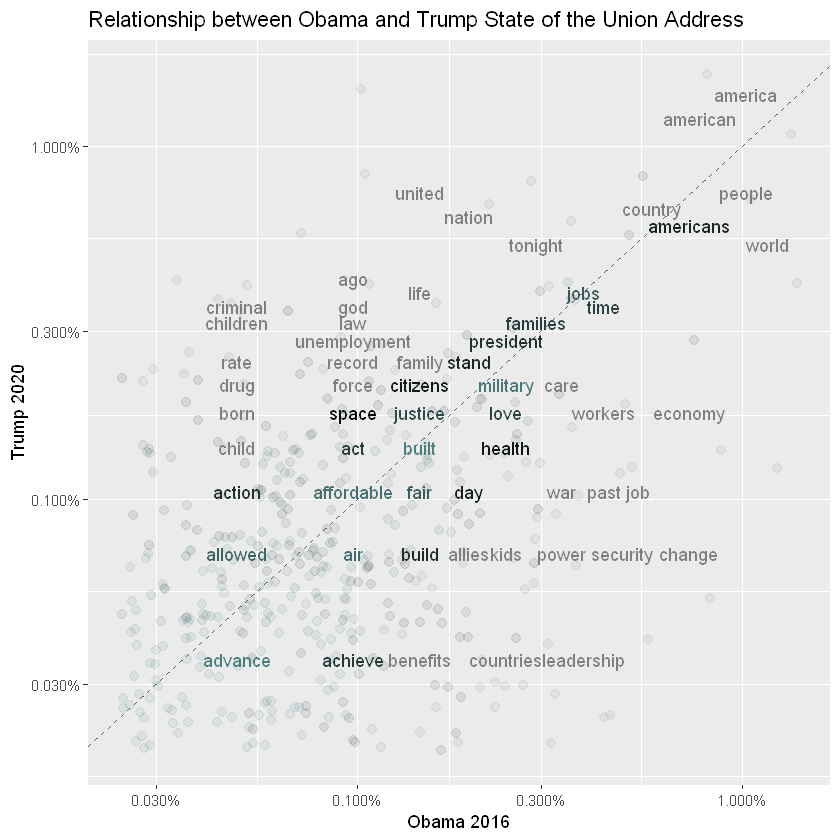

In [28]:
#Subset Obama and Trump speech
Obama_normalized <- subset(state_of_the_union_removed_stopwords, President == "Obama_2016")
Trump_normalized <- subset(state_of_the_union_removed_stopwords, President == "Trump_2020")

#Normalize word frequency
Obama_normalized$n <- Obama_normalized$n/sum(Obama_normalized$n)
Trump_normalized$n <- Trump_normalized$n/sum(Trump_normalized$n)

#Perform full join operation
Obama_Trump_normalized <- full_join(Obama_normalized, Trump_normalized, by = "word")

#Create scatter plot
ggplot(Obama_Trump_normalized, aes(x = n.x, y = n.y, color = abs(n.x - n.y))) +
  geom_abline(color = "gray40", lty = 2) +
  geom_jitter(alpha = 0.1, size = 2.5, width = 0.3, height = 0.3) +
  geom_text(aes(label = word), check_overlap = TRUE, vjust = 1.5) +
  scale_x_log10(labels = percent_format()) +
  scale_y_log10(labels = percent_format()) +
  scale_color_gradient(limits = c(0, 0.001), low = "darkslategray4", high = "black") +
  ggtitle("Relationship between Obama and Trump State of the Union Address") +
  theme(legend.position="none") +
  labs(y = "Trump 2020", x = "Obama 2016")

## Pearson’s Correlation Coefficient 

In [29]:
# Combine numeric vectors 
Obama_Trump_Similarity <- cbind(Obama_Trump_normalized$n.x, Obama_Trump_normalized$n.y)

#replace NaNs with zero
Obama_Trump_Similarity[is.na(Obama_Trump_Similarity)] <- 0
#Calculate Correlation
speech_correlation <- cor(Obama_Trump_Similarity)
print(paste("Correlation between Trump and Obama Speech = ", speech_correlation[1,2]))

[1] "Correlation between Trump and Obama Speech =  0.397054611207509"


# Lastly, let's perform  sentiment analysis. This time, we will go through all the steps we went through above, but do it in a few lines of code.

### Different sentiment lexicons can be utilized in order to calculate the overall sentiment in particular texts. Below, I use the Bing sentiment lexicon which classifies words as either positive or negative.

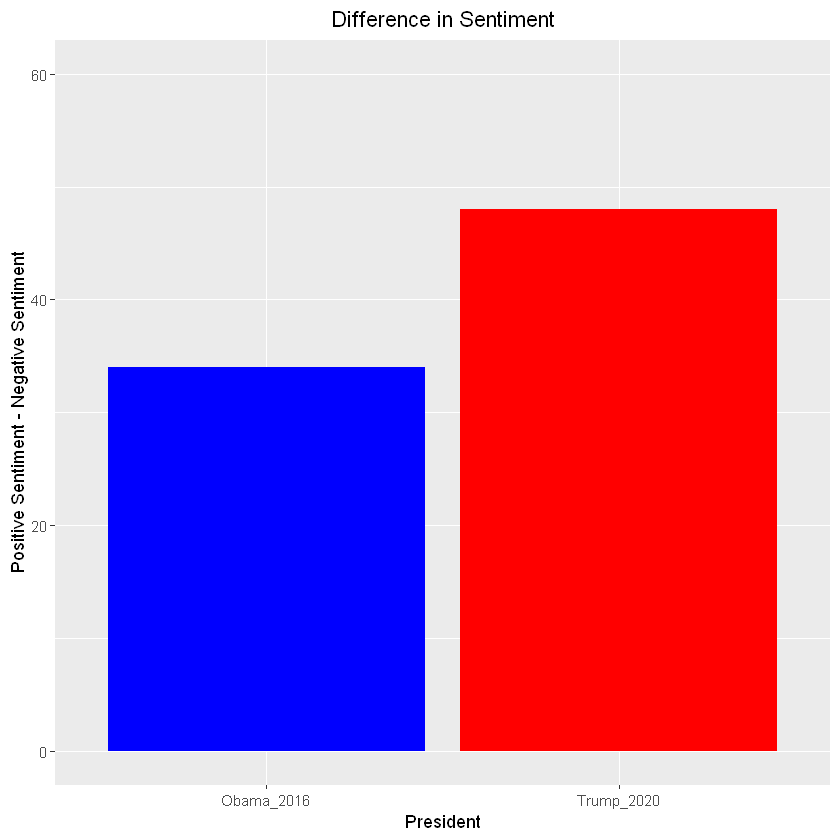

In [30]:
#Calculate the difference  between the positive and negative sentiment 
state_of_the_union_sentiment <- state_of_the_union_df %>%
     group_by(President) %>%
	 unnest_tokens(word, text) %>%
     anti_join(stop_words, by = "word") %>%
     inner_join(get_sentiments("bing"), by = "word") %>%
     count(sentiment) %>%
     spread(sentiment,n,fill=0) %>%
     mutate(diff = positive - negative)

# Plot the sentiment difference 
ggplot(data = state_of_the_union_sentiment, aes(x = President, y = diff)) + 
    geom_col(fill = c("blue", "red")) +
    ylim(0, 60) +
    ylab("Positive Sentiment - Negative Sentiment") + 
    ggtitle("Difference in Sentiment") +
    theme(plot.title = element_text(hjust = 0.5)) 


### So, it look like Trump's state of the union (2020) address was more positive overall than Obama's state of the union address (2016). This could be a result of many different things, such as economy at the time and more. 

### Please note that the above sentiment difference was not normalized 

# You can also use different sentiment lexicons via the tidy text package 

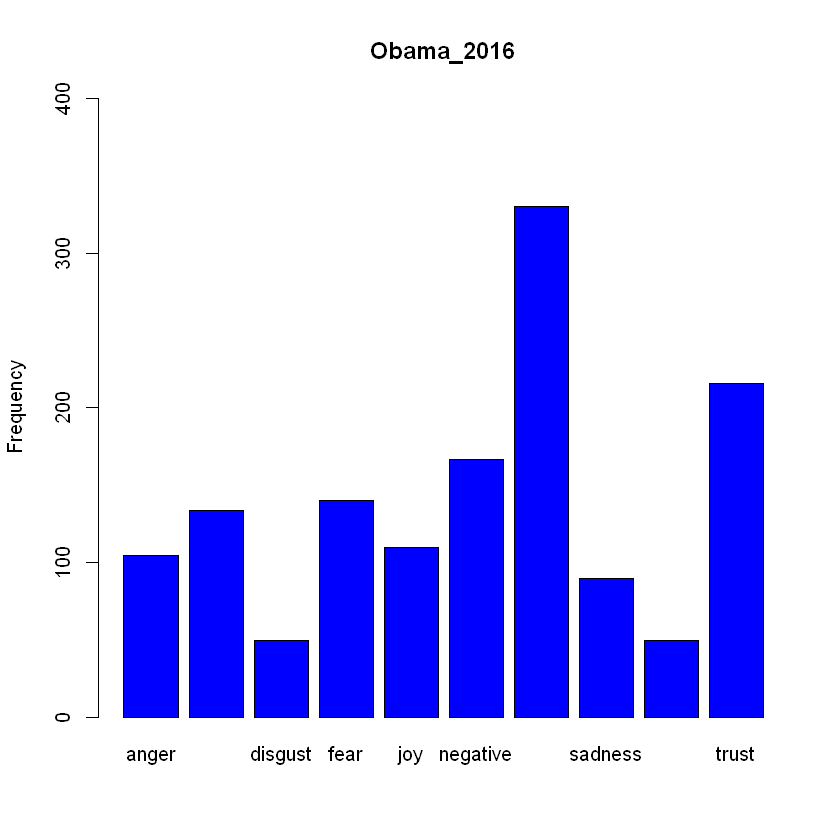

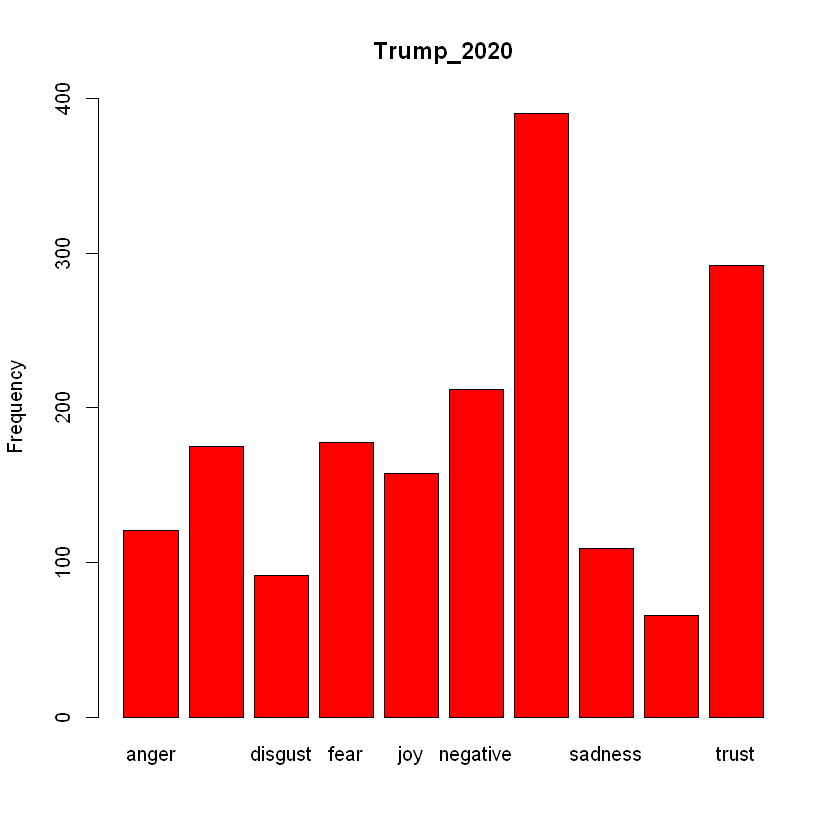

In [31]:
state_of_the_union_sentiment <- state_of_the_union_df %>%
     group_by(President) %>%
	 unnest_tokens(word, text) %>%
     anti_join(stop_words, by = "word") %>%
     inner_join(get_sentiments("nrc"), by = "word") %>%
     count(sentiment) %>%
     spread(sentiment,n,fill=0)

#Plot Obama and Trump Sentiment
barplot(as.matrix(state_of_the_union_sentiment[state_of_the_union_sentiment$President == "Obama_2016", 2:ncol(state_of_the_union_sentiment)]), col = "blue", main = "Obama_2016", ylim = c(0, 400), ylab = "Frequency")
barplot(as.matrix(state_of_the_union_sentiment[state_of_the_union_sentiment$President == "Trump_2020", 2:ncol(state_of_the_union_sentiment)]), col = "red", main = "Trump_2020", ylim = c(0, 400), ylab = 'Frequency')


## If you have any questions about my code or I how I performed a certain analysis, please feel free to contact me. 